# Convolutional Neural Networks with TensorFlow

"Deep Learning" is a general term that usually refers to the use of neural networks with multiple layers that synthesize the way the human brain learns and makes decisions. A convolutional neural network is a kind of neural network that extracts *features* from matrices of numeric values (often images) by convolving multiple filters over the matrix values to apply weights and identify patterns, such as edges, corners, and so on in an image. The numeric representations of these patterns are then passed to a fully-connected neural network layer to map the features to specific classes.

There are several commonly used frameworks for creating CNNs. In this notebook, we'll build a simple example CNN using TensorFlow.

## Install and import libraries

First, let's install and import the TensorFlow libraries we'll need.

In [1]:
# !pip install --upgrade tensorflow

In [2]:
import tensorflow as tf
import keras
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


## Explore the data

In this exercise, you'll train a CNN-based classification model that can classify images of geometric shapes. Let's take a look at the classes of shape the model needs to identify.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

In [4]:
# The images are in the data/shapes folder
data_folder = 'data/shapes'

In [5]:
# Get the class names
classnames = os.listdir(data_folder)
classnames.sort()
print(len(classnames), 'classes:')
print(classnames)

3 classes:
['circle', 'square', 'triangle']


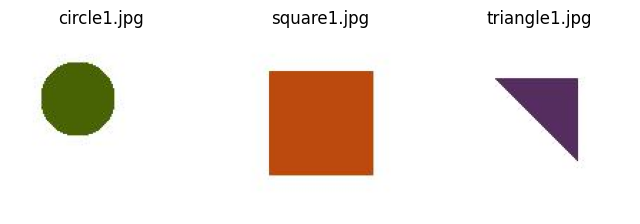

In [ ]:
# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classnames),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

## Prepare the data

Before we can train the model, we need to prepare the data. We'll divide the feature values by 255 to normalize them as floating point values between 0 and 1, and we'll split the data so that we can use 70% of it to train the model, and hold back 30% to validate it. When loading the data, the data generator will assign "hot-encoded" numeric labels to indicate which class each image belongs to based on the subfolders in which the data is stored. In this case, there are three subfolders - *circle*, *square*, and *triangle*, so the labels will consist of three *0* or *1* values indicating which of these classes is associated with the image - for example the label [0 1 0] indicates that the image belongs to the second class (*square*).

In [7]:
"""
# this code is deprecated
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')
"""

'\n# this code is deprecated\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\nimg_size = (128, 128)\nbatch_size = 30\n\nprint("Getting Data...")\ndatagen = ImageDataGenerator(rescale=1./255, # normalize pixel values\n                             validation_split=0.3) # hold back 30% of the images for validation\n\nprint("Preparing training dataset...")\ntrain_generator = datagen.flow_from_directory(\n    data_folder,\n    target_size=img_size,\n    batch_size=batch_size,\n    class_mode=\'categorical\',\n    subset=\'training\') # set as training data\n\nprint("Preparing validation dataset...")\nvalidation_generator = datagen.flow_from_directory(\n    data_folder,\n    target_size=img_size,\n    batch_size=batch_size,\n    class_mode=\'categorical\',\n    subset=\'validation\') # set as validation data\n\nclassnames = list(train_generator.class_indices.keys())\nprint(\'Data generators ready\')\n'

In [8]:
dir(keras.api.preprocessing.image)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'array_to_img',
 'img_to_array',
 'load_img',
 'save_img',
 'smart_resize']

In [9]:
from keras.api.preprocessing import image_dataset_from_directory

In [10]:
# Configuration
img_size = (128, 128)  # Image resize target
batch_size = 30

# Load the dataset
train_dataset: tf.data.Dataset = image_dataset_from_directory(
    data_folder,
    validation_split=0.3,
    subset="training",
    seed=123,  # Random seed for reproducibility
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'  # This will load labels as integers (not one-hot encoded yet)
)

validation_dataset: tf.data.Dataset = image_dataset_from_directory(
    data_folder,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'  # Labels are integers here too
)

Found 1200 files belonging to 3 classes.
Using 840 files for training.
Found 1200 files belonging to 3 classes.
Using 360 files for validation.


In [11]:
# Access class names directly from the dataset object
# redundant because we had already extracted the class names from the folder structure
# classnames = train_dataset.class_names
# print(f"Classes: {classnames}")

Classes: ['circle', 'square', 'triangle']


In [12]:
# Normalize the images by dividing by 255
def normalize_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_dataset = train_dataset.map(normalize_images)
validation_dataset = validation_dataset.map(normalize_images)

First batch of images: tf.Tensor(
[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.     

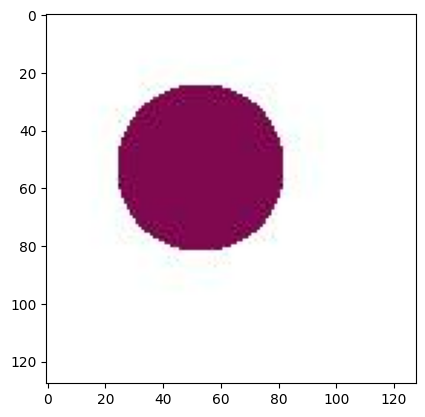

In [13]:
# Optional - see the intermediate results...

# Get a batch of data from the train_dataset
for images, labels in train_dataset.take(1):  # Take the first batch (1 batch)
    print("First batch of images:", images)
    print("First batch of labels:", labels)

    # Optionally, print the shape and a single image (to inspect the data)
    images: tf.Tensor; labels: tf.Tensor
    print("Shape of images batch:", images.shape)  # (batch_size, height, width, channels)
    print("Shape of labels batch:", labels.shape)  # (batch_size, num_classes)
    
    # Optionally, if you want to see the first image in the batch
    import matplotlib.pyplot as plt
    plt.imshow(images[0])  # Display the first image in the batch
    plt.show()
    break  # We only need to look at the first batch, so break the loop

In [14]:
# One-hot encode the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=len(classnames))  # One-hot encode labels
    return image, label

train_dataset = train_dataset.map(one_hot_encode)
validation_dataset = validation_dataset.map(one_hot_encode)

In [15]:
# Prepare dataset for performance (prefetching, batching)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Data generators are ready
print("Data pipelines are ready for training")

Data pipelines are ready for training


Instead of this you can read the labels and encode in one step

In [ ]:
# Define the input shape (128x128 with 3 channels - RGB)
input_shape = (128, 128, 3)

train_dataset: tf.data.Dataset = image_dataset_from_directory(
    data_folder, 
    image_size=input_shape[:2],  # Resize images to 128x128
    batch_size=batch_size,
    validation_split=0.3,
    subset="training",
    seed=123,
    label_mode='categorical' # one-hot encode
)

validation_dataset: tf.data.Dataset = image_dataset_from_directory(
    data_folder,
    image_size=input_shape[:2],
    batch_size=batch_size,
    validation_split=0.3,
    subset="validation",
    seed=123,
    label_mode='categorical'
)

# and normalize afterwards
train_dataset = train_dataset.map(normalize_images)
validation_dataset = validation_dataset.map(normalize_images)

# (Optional) "Optimization" aka no idea what this does
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 1200 files belonging to 3 classes.
Using 840 files for training.
Found 1200 files belonging to 3 classes.
Using 360 files for validation.


## Define the CNN

Now we're ready to create our model. This involves defining the layers for our CNN, and compiling them for multi-class classification.

In [17]:
# Check the shape of a batch in the train_dataset
for images, labels in train_dataset.take(1):
    images: tf.Tensor; labels: tf.Tensor
    print(images.shape)  # Ensure this matches (batch_size, 128, 128, 3)
    print(labels.shape)  # Ensure this matches (batch_size, num_classes)

(30, 128, 128, 3)
(30, 3)


Using the Sequential API

In [18]:
# Define a CNN classifier network
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

num_classes = len(classnames)  # Number of output classes
input_shape = (128, 128, 3)  # Images of size 128x128 with 3 color channels (RGB)

# Define the model as a sequence of layers
model: keras.Model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a ReLU activation function
# model.add(Conv2D(32, (6, 6), input_shape=input_shape, activation='relu'))
model.add(Input(shape=input_shape)) # Add the Input layer explicitly
# The first convolution layer applies a 32 6x6 filters and uses ReLU activation
model.add(Conv2D(32, (6, 6), activation='relu'))

# Next, we add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2, 2)))

# We can add more layers as needed - here another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Another set of Conv2D and MaxPooling2D layers
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer to prevent overfitting by randomly dropping nodes
model.add(Dropout(0.2))

# Flatten the feature maps to feed into a fully connected layer
model.add(Flatten())

# Fully connected output layer with softmax activation for multi-class classification
# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model for categorical (multi-class) classification
# With the layers defined, we can now compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary to inspect the architecture
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 123, 123, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        11,619 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,899 (347.26 KB)

 Trainable params: 88,899 (347.26 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# create a copy

from keras.api.models import clone_model

# Clone the model architecture
sequential_model = clone_model(model)
sequential_model.build(input_shape=(None, 128, 128, 3))  # Provide the input shape

# Copy weights
sequential_model.set_weights(model.get_weights())

Same thing using the Functional API instead

In [20]:
# Determine the number of output classes
num_classes = len(classnames)

# Define the input shape (128x128 with 3 channels - RGB)
input_shape = (128, 128, 3)

# Define the model using the functional API
inputs: Input = Input(shape=input_shape)

# Add the convolutional layers
x = Conv2D(32, (6, 6), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (6, 6), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (6, 6), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Add dropout for regularization
x = Dropout(0.2)(x)

# Flatten the feature maps
x = Flatten()(x)

# Output layer with softmax activation for multi-class classification
output = Dense(num_classes, activation='softmax')(x)  # Use num_classes here

# Create the model
model: keras.Model = keras.Model(inputs=inputs, outputs=output)

# Compile the model for categorical classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 123, 123, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 23, 23, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │        11,619 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,899 (347.26 KB)

 Trainable params: 88,899 (347.26 KB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
functional_model = clone_model(model)
functional_model.build(input_shape=(None, 128, 128, 3))
functional_model.set_weights(model.get_weights())

## Train the model

With the layers of the CNN defined, we're ready to train the model using our image data. In the example below, we use 5 iterations (*epochs*) to train the model in 30-image batches, holding back 30% of the data for validation. After each epoch, the loss function measures the error (*loss*) in the model and adjusts the weights (which were randomly generated for the first iteration) to try to improve accuracy. 

> **Note**: We're only using 5 epochs to minimize the training time for this simple example. A real-world CNN is usually trained over more epochs than this. CNN model training is processor-intensive, involving a lot of matrix and vector-based operations; so it's recommended to perform this on a system that can leverage GPUs, which are optimized for these kinds of calculation. This will take a while to complete on a CPU-based system - status will be displayed as the training progresses.

In [22]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation

# Batch the datasets
batch_size = 30 # set the batch size

batching_done = True

if batching_done:
    print("The images were already batched - when they were loaded")
    pass
else:
    # just for exemplification purposes

    for images, labels in train_dataset.take(1):
        images: tf.Tensor; labels: tf.Tensor
        print(images.shape)
        print(labels.shape)

    # Reset the pipeline to remove redundant batching
    train_dataset = train_dataset.unbatch()  # Remove any previous batching
    validation_dataset = validation_dataset.unbatch()

    for images, labels in train_dataset.take(1):
        images: tf.Tensor; labels: tf.Tensor
        print(images.shape)
        print(labels.shape)

    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    for images, labels in train_dataset.take(1):
        images: tf.Tensor; labels: tf.Tensor
        print(images.shape)  # Should print (batch_size, 128, 128, 3)
        print(labels.shape)  # Should print (batch_size, num_classes)

The images were already batched - when they were loaded


In [23]:
print(f"Number of batches in training dataset: {len(list(train_dataset))}")
print(f"Number of batches in validation dataset: {len(list(validation_dataset))}")
print(model.input_shape)
print(f"Number of classes: {num_classes}")  # Should match the last layer in the model


Number of batches in training dataset: 28
Number of batches in validation dataset: 12
(None, 128, 128, 3)
Number of classes: 3


In [24]:
# Set the number of epochs
epochs = 5

# Train the model using the .fit() method, specifying both training and validation datasets
# Train the model
history: keras.callbacks.History = model.fit(
    train_dataset,               # Batched training dataset
    epochs=epochs,                    # Number of epochs
    validation_data=validation_dataset,  # Batched validation dataset
    # verbose=1                    # Display progress bar
    verbose=2  # Display detailed progress
)

# Optionally, print the training history for review
print(f"Training history: {history.history}")

Epoch 1/5
28/28 - 7s - 235ms/step - accuracy: 0.5929 - loss: 0.7620 - val_accuracy: 0.6667 - val_loss: 0.4841
Epoch 2/5
28/28 - 5s - 169ms/step - accuracy: 0.8690 - loss: 0.2799 - val_accuracy: 0.9528 - val_loss: 0.1227
Epoch 3/5
28/28 - 5s - 179ms/step - accuracy: 0.9714 - loss: 0.0758 - val_accuracy: 1.0000 - val_loss: 0.0166
Epoch 4/5
28/28 - 5s - 167ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 5/5
28/28 - 5s - 175ms/step - accuracy: 0.9988 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0030
Training history: {'accuracy': [0.5928571224212646, 0.8690476417541504, 0.9714285731315613, 0.9964285492897034, 0.9988095164299011], 'loss': [0.7619858384132385, 0.279913991689682, 0.07583379000425339, 0.014530254527926445, 0.008681360632181168], 'val_accuracy': [0.6666666865348816, 0.9527778029441833, 1.0, 1.0, 1.0], 'val_loss': [0.4841051399707794, 0.12271254509687424, 0.016613179817795753, 0.005982460454106331, 0.0030077314004302025]}


## View the loss history

We tracked average training and validation loss history for each epoch. We can plot these to verify that loss reduced as the model was trained, and to detect *overfitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

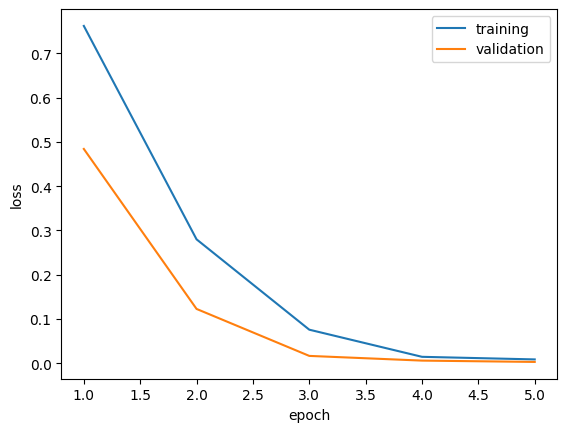

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1, epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluate model performance

We can see the final accuracy based on the test data, but typically we'll want to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.

Generating predictions from validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


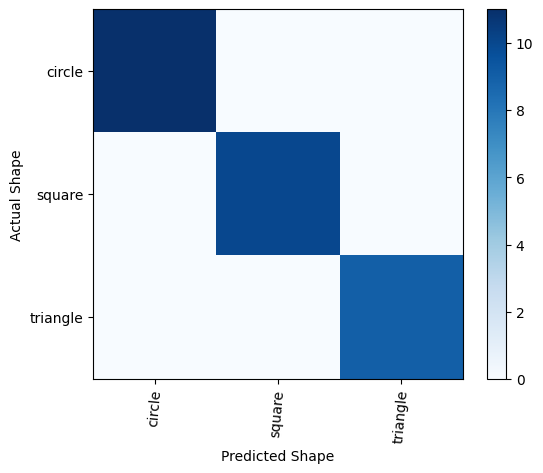

In [30]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
for x_test, y_test in validation_dataset.take(1):
    x_test: tf.Tensor; y_test: tf.Tensor
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    # not sure if this works for any tensor. Here's another way
    
    # x_test = x_test.numpy()  # Convert tensors to numpy arrays
    # y_test = y_test.numpy()
    # Add explicit type hints after conversion
    # x_test: np.ndarray
    # y_test: np.ndarray

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Save the Trained model

Now that you've trained a working model, you can save it (including the trained weights) for use later.

In [31]:
# Save the trained model
modelFileName = 'models/shape_classifier.keras'
model.save(modelFileName)
print('model saved as', modelFileName)

model saved as models/shape_classifier.keras


In [32]:
del model  # deletes the existing model variable

## Use the trained model

When you have a new image, you can use the saved model to predict its class.

In [ ]:
import numpy as np
from random import randint
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((128,128), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
model = keras.models.load_model(modelFileName) # loads the saved model
class_idx = predict_image(model, img)
print (classnames[class_idx])

In [33]:
from PIL import Image, ImageDraw
from random import randint

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted class: circle


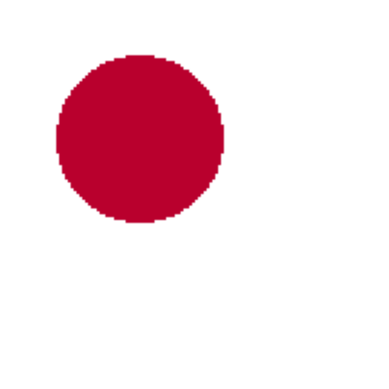

In [38]:
# Function to predict the class of an image
def predict_image(classifier: keras.models.Model, image: np.ndarray):
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # Normalize the image (divide by 255 to match training preprocessing)
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255

    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)

    # Find the class prediction with the highest predicted probability
    index = np.argmax(class_probabilities, axis=1)[0]
    return index

# Function to create a random image (square, circle, or triangle)
def create_image(size, shape):
    xy1 = randint(10, 40)
    xy2 = randint(60, 100)
    col = (randint(0, 200), randint(0, 200), randint(0, 200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)

    if shape == 'circle':
        draw.ellipse([(xy1, xy1), (xy2, xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1, xy1), (xy2, xy2), (xy2, xy1)], fill=col)
    else:  # square
        draw.rectangle([(xy1, xy1), (xy2, xy2)], fill=col)
    del draw

    return np.array(img)

# Load class names (for example, your shapes folder has class labels)
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()

# Create a random test image from one of the class names
img = create_image((128, 128), classnames[randint(0, len(classnames)-1)])

# Display the image
plt.axis('off')
plt.imshow(img)

# Load the model
model = keras.models.load_model(modelFileName)

# Predict the class for the created image
class_idx = predict_image(model, img)

# Print the predicted class
print("Predicted class:", classnames[class_idx])

## Further Reading

To learn more about training convolutional neural networks with TensorFlow, see the [TensorFlow documentation](https://www.tensorflow.org/overview).

## Challenge: Safari Image Classification

Hopefully this notebook has shown you the main steps in training and evaluating a CNN. Why not put what you've learned into practice with our Safari image classification challenge in the [/challenges/05 - Safari CNN Challenge.ipynb](./challenges/05%20-%20Safari%20CNN%20Challenge.ipynb) notebook?

> **Note**: The time to complete this optional challenge is not included in the estimated time for this exercise - you can spend as little or as much time on it as you like!